In [1]:
import os
import math
import random
from pathlib import Path
from typing import Tuple, Optional, List, Dict

import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision import transforms, utils as tv_utils
from PIL import Image
import matplotlib.pyplot as plt
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
HF_DATASET_ID = "valhalla/emoji-dataset"
IMAGE_SIZE = 64
NUM_WORKERS =  2

EPOCHS = 200
LR = 2e-4
CODEBOOK_RESET_INTERVAL = 5
EMA_DECAY = 0.99

BATCH_SIZE = 128
HIDDEN_DIMS = [128, 256]
LATENT_DIM = 256
NUM_EMBEDDINGS = 512
COMMITMENT_COST = 0.25
RES_BLOCKS = 2
CHECKPOINT_PATH = "vqvae_checkpoint.pt"
BEST_MODEL_PATH = "vqvae_best.pt"

In [4]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item["image"]
        if self.transform:
            img = self.transform(img)
        label = item.get("text", "")
        return img, label

In [5]:
def get_hf_dataloader(dataset_id=HF_DATASET_ID, split="train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True):
    print(f"Loading HuggingFace dataset `{dataset_id}` split='{split}' ...")
    hf_ds = load_dataset(dataset_id, split=split)
    print(f"Dataset loaded. Examples: {len(hf_ds)}")
    transform = Compose([
        Resize((image_size, image_size)),
        RandomHorizontalFlip(),
        ToTensor(),
    ])
    wrapped = HFDatasetWrapper(hf_ds, transform=transform)
    loader = DataLoader(wrapped, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True)
    return loader

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return F.relu(x + residual)

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, latent_dim, num_res_blocks):
        super().__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_dims[0], 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        for i in range(len(hidden_dims) - 1):
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i]))
            modules.append(nn.Sequential(
                nn.Conv2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[-1]))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], latent_dim, 1),
            nn.BatchNorm2d(latent_dim)
        ))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, out_channels, num_res_blocks):
        super().__init__()
        modules = []

        modules.append(nn.Sequential(
            nn.Conv2d(latent_dim, hidden_dims[0], 1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))
        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[0]))

        for i in range(len(hidden_dims) - 1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i+1]))

        modules.append(nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1] // 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[-1] // 2),
            nn.ReLU()
        ))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1] // 2, out_channels, 3, padding=1),
            nn.Sigmoid()
        ))

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

In [9]:
class EMAQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay=0.99):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay

        self.register_buffer('embedding', torch.randn(num_embeddings, embedding_dim))

        self.register_buffer('cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('embedding_avg', torch.randn(num_embeddings, embedding_dim))
        self.register_buffer('code_usage_counter', torch.zeros(num_embeddings, dtype=torch.long))

    def forward(self, z):
        z_permuted = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z_permuted.view(-1, self.embedding_dim)

        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding**2, dim=1)
                    - 2 * torch.matmul(z_flattened, self.embedding.t()))

        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).float()

        quantized = torch.matmul(encodings, self.embedding).view(z_permuted.shape)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(torch.sum(encodings, dim=0), alpha=1 - self.decay)
            self.embedding_avg.data.mul_(self.decay).add_(torch.matmul(encodings.t(), z_flattened), alpha=1 - self.decay)

            n = torch.sum(self.cluster_size)
            cluster_size_smooth = (self.cluster_size + 1e-5) / (n + self.num_embeddings * 1e-5) * n

            self.embedding.data.copy_(self.embedding_avg / cluster_size_smooth.unsqueeze(1))

            unique, counts = torch.unique(encoding_indices, return_counts=True)
            self.code_usage_counter[unique] += counts

        e_latent_loss = F.mse_loss(quantized.detach(), z_permuted)
        loss = self.commitment_cost * e_latent_loss

        quantized = z_permuted + (quantized - z_permuted).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        avg_probs = torch.mean(encodings, dim=0)

        return quantized, loss, encoding_indices.view(z.shape[0], z.shape[2], z.shape[3])

    def reset_unused_codes(self, batch_latents):
        unused_indices = torch.where(self.code_usage_counter == 0)[0]
        if len(unused_indices) == 0:
            return

        print(f"Resetting {len(unused_indices)} unused codebook vectors.")

        z_flattened = batch_latents.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)
        random_latents = z_flattened[torch.randint(0, z_flattened.size(0), (len(unused_indices),))]

        self.embedding.data[unused_indices] = random_latents
        self.cluster_size.data[unused_indices] = 1.0
        self.embedding_avg.data[unused_indices] = random_latents

        self.code_usage_counter.zero_()

    def code_usage_percentage(self):
        used_codes = torch.sum(self.code_usage_counter > 0).item()
        return (used_codes / self.num_embeddings) * 100.0

In [10]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, hidden_dims, latent_dim, num_embeddings, commitment_cost, num_res_blocks, ema_decay):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_dims, latent_dim, num_res_blocks)
        self.vq = EMAQuantizer(num_embeddings, latent_dim, commitment_cost, decay=ema_decay)
        self.decoder = Decoder(latent_dim, list(reversed(hidden_dims)), in_channels, num_res_blocks)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, indices = self.vq(z)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss, indices

In [11]:
def train_vqvae(model: VQVAE, dataloader: DataLoader, epochs=EPOCHS, lr=LR, device=DEVICE):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, eta_min=1e-6)

    history = {"loss": [], "recon_loss": [], "vq_loss": [], "usage_pct": []}

    for ep in range(1, epochs+1):
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {ep}/{epochs}")
        epoch_loss = 0.0
        epoch_vq_loss = 0.0
        epoch_recon = 0.0
        n_seen = 0
        for batch in pbar:
            imgs = batch[0].to(device)
            opt.zero_grad()

            z = model.encoder(imgs)
            quantized, vq_loss, indices = model.vq(z)
            recon = model.decoder(quantized)

            recon_loss = F.mse_loss(recon, imgs)
            loss = recon_loss + vq_loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            opt.step()

            batch_size = imgs.size(0)
            epoch_loss += loss.item() * batch_size
            epoch_vq_loss += vq_loss.item() * batch_size
            epoch_recon += recon_loss.item() * batch_size
            n_seen += batch_size
            pbar.set_postfix({"loss": epoch_loss / n_seen, "recon": epoch_recon/n_seen})

        if scheduler:
            scheduler.step()

        usage_pct = model.vq.code_usage_percentage()
        avg_loss = epoch_loss / n_seen
        history["loss"].append(avg_loss)
        history["recon_loss"].append(epoch_recon / n_seen)
        history["vq_loss"].append(epoch_vq_loss / n_seen)
        history["usage_pct"].append(usage_pct)
        print(f"Epoch {ep} | loss: {avg_loss:.4f} | recon: {history['recon_loss'][-1]:.4f} | codebook usage: {usage_pct:.2f}%")

        if ep % CODEBOOK_RESET_INTERVAL == 0:
            sample_batch = next(iter(dataloader))
            sample_latents = model.encoder(sample_batch[0].to(device))
            with torch.no_grad():
                 model.vq.reset_unused_codes(sample_latents)
    return history

In [12]:
def plot_vq_history(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["loss"], label="total_loss", color='tab:blue')
    plt.legend()
    plt.title("VQ-VAE Total Loss")
    plt.subplot(1,2,2)
    plt.plot(history["usage_pct"], label="codebook % used", color='tab:orange')
    plt.legend()
    plt.title("Codebook Usage (%)")
    plt.tight_layout()
    plt.show()

In [13]:
def show_image_tensor_grid(tensor_batch, ncols=8, title=None):
    grid = tv_utils.make_grid(tensor_batch.detach().cpu(), nrow=ncols, pad_value=1.0)
    npimg = grid.numpy().transpose(1,2,0)
    plt.figure(figsize=(10, 10 * (grid.shape[1] / grid.shape[2])))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(npimg)
    plt.show()

def visualize_reconstructions(model: VQVAE, dataloader: DataLoader, n=8, device=DEVICE):
    model.eval()
    dataset = dataloader.dataset
    indices = random.sample(range(len(dataset)), n)
    imgs = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        recon, _, indices = model(imgs)
    stacked = torch.cat([imgs.cpu(), recon.cpu()], dim=0)
    show_image_tensor_grid(stacked, ncols=n, title="Top row: Original | Bottom row: Reconstruction")

In [14]:
 train_loader = get_hf_dataloader(
        dataset_id="valhalla/emoji-dataset",
        split="train",
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

Loading HuggingFace dataset `valhalla/emoji-dataset` split='train' ...


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Dataset loaded. Examples: 2749


In [15]:
vq_vae_model = VQVAE(
        in_channels=3,
        hidden_dims=HIDDEN_DIMS,
        latent_dim=LATENT_DIM,
        num_embeddings=NUM_EMBEDDINGS,
        commitment_cost=COMMITMENT_COST,
        num_res_blocks=RES_BLOCKS,
        ema_decay=EMA_DECAY
    ).to(DEVICE)

In [16]:
history = train_vqvae(vq_vae_model, train_loader, epochs=EPOCHS, lr=LR, device=DEVICE)

Epoch 1/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 | loss: 0.1362 | recon: 0.0642 | codebook usage: 87.30%


Epoch 2/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 | loss: 0.0415 | recon: 0.0274 | codebook usage: 87.30%


Epoch 3/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 | loss: 0.0323 | recon: 0.0207 | codebook usage: 87.30%


Epoch 4/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 | loss: 0.0276 | recon: 0.0175 | codebook usage: 87.30%


Epoch 5/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 | loss: 0.0246 | recon: 0.0154 | codebook usage: 87.30%
Resetting 65 unused codebook vectors.


Epoch 6/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 | loss: 0.0159 | recon: 0.0123 | codebook usage: 17.77%


Epoch 7/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 | loss: 0.0139 | recon: 0.0110 | codebook usage: 17.77%


Epoch 8/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 | loss: 0.0130 | recon: 0.0103 | codebook usage: 17.77%


Epoch 9/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 | loss: 0.0122 | recon: 0.0096 | codebook usage: 17.77%


Epoch 10/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 | loss: 0.0116 | recon: 0.0091 | codebook usage: 17.77%
Resetting 421 unused codebook vectors.


Epoch 11/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 | loss: 0.0092 | recon: 0.0078 | codebook usage: 99.41%


Epoch 12/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 | loss: 0.0078 | recon: 0.0066 | codebook usage: 99.41%


Epoch 13/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 | loss: 0.0075 | recon: 0.0063 | codebook usage: 99.41%


Epoch 14/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 | loss: 0.0070 | recon: 0.0059 | codebook usage: 99.41%


Epoch 15/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 | loss: 0.0066 | recon: 0.0055 | codebook usage: 99.41%
Resetting 3 unused codebook vectors.


Epoch 16/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 | loss: 0.0064 | recon: 0.0053 | codebook usage: 96.29%


Epoch 17/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 | loss: 0.0061 | recon: 0.0050 | codebook usage: 97.07%


Epoch 18/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 | loss: 0.0060 | recon: 0.0049 | codebook usage: 97.07%


Epoch 19/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 | loss: 0.0057 | recon: 0.0047 | codebook usage: 97.07%


Epoch 20/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 | loss: 0.0055 | recon: 0.0045 | codebook usage: 97.07%
Resetting 15 unused codebook vectors.


Epoch 21/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21 | loss: 0.0056 | recon: 0.0046 | codebook usage: 97.66%


Epoch 22/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22 | loss: 0.0054 | recon: 0.0044 | codebook usage: 97.66%


Epoch 23/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23 | loss: 0.0052 | recon: 0.0042 | codebook usage: 98.44%


Epoch 24/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 24 | loss: 0.0052 | recon: 0.0042 | codebook usage: 98.44%


Epoch 25/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25 | loss: 0.0051 | recon: 0.0041 | codebook usage: 98.44%
Resetting 8 unused codebook vectors.


Epoch 26/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26 | loss: 0.0050 | recon: 0.0041 | codebook usage: 98.63%


Epoch 27/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27 | loss: 0.0049 | recon: 0.0040 | codebook usage: 98.83%


Epoch 28/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28 | loss: 0.0049 | recon: 0.0039 | codebook usage: 98.83%


Epoch 29/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 29 | loss: 0.0047 | recon: 0.0037 | codebook usage: 99.22%


Epoch 30/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30 | loss: 0.0048 | recon: 0.0039 | codebook usage: 99.22%
Resetting 4 unused codebook vectors.


Epoch 31/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 31 | loss: 0.0047 | recon: 0.0038 | codebook usage: 99.22%


Epoch 32/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 32 | loss: 0.0045 | recon: 0.0036 | codebook usage: 99.22%


Epoch 33/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 33 | loss: 0.0047 | recon: 0.0038 | codebook usage: 99.41%


Epoch 34/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 34 | loss: 0.0044 | recon: 0.0035 | codebook usage: 99.41%


Epoch 35/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 35 | loss: 0.0043 | recon: 0.0034 | codebook usage: 99.41%
Resetting 3 unused codebook vectors.


Epoch 36/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 36 | loss: 0.0044 | recon: 0.0036 | codebook usage: 99.22%


Epoch 37/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 37 | loss: 0.0041 | recon: 0.0033 | codebook usage: 99.41%


Epoch 38/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 38 | loss: 0.0041 | recon: 0.0033 | codebook usage: 99.41%


Epoch 39/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 39 | loss: 0.0040 | recon: 0.0032 | codebook usage: 99.41%


Epoch 40/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 40 | loss: 0.0041 | recon: 0.0033 | codebook usage: 99.41%
Resetting 3 unused codebook vectors.


Epoch 41/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 41 | loss: 0.0040 | recon: 0.0032 | codebook usage: 99.80%


Epoch 42/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 42 | loss: 0.0039 | recon: 0.0031 | codebook usage: 99.80%


Epoch 43/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 43 | loss: 0.0040 | recon: 0.0032 | codebook usage: 99.80%


Epoch 44/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 44 | loss: 0.0040 | recon: 0.0032 | codebook usage: 99.80%


Epoch 45/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 45 | loss: 0.0039 | recon: 0.0031 | codebook usage: 99.80%
Resetting 1 unused codebook vectors.


Epoch 46/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 46 | loss: 0.0038 | recon: 0.0031 | codebook usage: 99.80%


Epoch 47/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 47 | loss: 0.0040 | recon: 0.0032 | codebook usage: 99.80%


Epoch 48/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 48 | loss: 0.0039 | recon: 0.0031 | codebook usage: 99.80%


Epoch 49/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 49 | loss: 0.0037 | recon: 0.0030 | codebook usage: 99.80%


Epoch 50/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 50 | loss: 0.0037 | recon: 0.0029 | codebook usage: 99.80%
Resetting 1 unused codebook vectors.


Epoch 51/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 51 | loss: 0.0036 | recon: 0.0029 | codebook usage: 100.00%


Epoch 52/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 52 | loss: 0.0036 | recon: 0.0029 | codebook usage: 100.00%


Epoch 53/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 53 | loss: 0.0037 | recon: 0.0029 | codebook usage: 100.00%


Epoch 54/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 54 | loss: 0.0035 | recon: 0.0028 | codebook usage: 100.00%


Epoch 55/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 55 | loss: 0.0035 | recon: 0.0028 | codebook usage: 100.00%


Epoch 56/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 56 | loss: 0.0037 | recon: 0.0029 | codebook usage: 100.00%


Epoch 57/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 57 | loss: 0.0034 | recon: 0.0027 | codebook usage: 100.00%


Epoch 58/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 58 | loss: 0.0034 | recon: 0.0027 | codebook usage: 100.00%


Epoch 59/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 59 | loss: 0.0033 | recon: 0.0026 | codebook usage: 100.00%


Epoch 60/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 60 | loss: 0.0033 | recon: 0.0026 | codebook usage: 100.00%


Epoch 61/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 61 | loss: 0.0035 | recon: 0.0028 | codebook usage: 100.00%


Epoch 62/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 62 | loss: 0.0033 | recon: 0.0026 | codebook usage: 100.00%


Epoch 63/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 63 | loss: 0.0033 | recon: 0.0026 | codebook usage: 100.00%


Epoch 64/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 64 | loss: 0.0033 | recon: 0.0026 | codebook usage: 100.00%


Epoch 65/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 65 | loss: 0.0034 | recon: 0.0027 | codebook usage: 100.00%


Epoch 66/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 66 | loss: 0.0033 | recon: 0.0026 | codebook usage: 100.00%


Epoch 67/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 67 | loss: 0.0034 | recon: 0.0027 | codebook usage: 100.00%


Epoch 68/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 68 | loss: 0.0034 | recon: 0.0027 | codebook usage: 100.00%


Epoch 69/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 69 | loss: 0.0031 | recon: 0.0025 | codebook usage: 100.00%


Epoch 70/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 70 | loss: 0.0031 | recon: 0.0025 | codebook usage: 100.00%


Epoch 71/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 71 | loss: 0.0031 | recon: 0.0025 | codebook usage: 100.00%


Epoch 72/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 72 | loss: 0.0032 | recon: 0.0025 | codebook usage: 100.00%


Epoch 73/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 73 | loss: 0.0031 | recon: 0.0024 | codebook usage: 100.00%


Epoch 74/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 74 | loss: 0.0031 | recon: 0.0025 | codebook usage: 100.00%


Epoch 75/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 75 | loss: 0.0031 | recon: 0.0024 | codebook usage: 100.00%


Epoch 76/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 76 | loss: 0.0031 | recon: 0.0024 | codebook usage: 100.00%


Epoch 77/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 77 | loss: 0.0030 | recon: 0.0024 | codebook usage: 100.00%


Epoch 78/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 78 | loss: 0.0030 | recon: 0.0023 | codebook usage: 100.00%


Epoch 79/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 79 | loss: 0.0029 | recon: 0.0023 | codebook usage: 100.00%


Epoch 80/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 80 | loss: 0.0029 | recon: 0.0022 | codebook usage: 100.00%


Epoch 81/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 81 | loss: 0.0030 | recon: 0.0023 | codebook usage: 100.00%


Epoch 82/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 82 | loss: 0.0029 | recon: 0.0023 | codebook usage: 100.00%


Epoch 83/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 83 | loss: 0.0029 | recon: 0.0022 | codebook usage: 100.00%


Epoch 84/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 84 | loss: 0.0029 | recon: 0.0022 | codebook usage: 100.00%


Epoch 85/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 85 | loss: 0.0029 | recon: 0.0023 | codebook usage: 100.00%


Epoch 86/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 86 | loss: 0.0029 | recon: 0.0022 | codebook usage: 100.00%


Epoch 87/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 87 | loss: 0.0029 | recon: 0.0023 | codebook usage: 100.00%


Epoch 88/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 88 | loss: 0.0029 | recon: 0.0022 | codebook usage: 100.00%


Epoch 89/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 89 | loss: 0.0028 | recon: 0.0021 | codebook usage: 100.00%


Epoch 90/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 90 | loss: 0.0028 | recon: 0.0021 | codebook usage: 100.00%


Epoch 91/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 91 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 92/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 92 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 93/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 93 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 94/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 94 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 95/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 95 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 96/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 96 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 97/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 97 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 98/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 98 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 99/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 99 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 100/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 100 | loss: 0.0027 | recon: 0.0020 | codebook usage: 100.00%


Epoch 101/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 101 | loss: 0.0027 | recon: 0.0021 | codebook usage: 100.00%


Epoch 102/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 102 | loss: 0.0026 | recon: 0.0020 | codebook usage: 100.00%


Epoch 103/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 103 | loss: 0.0027 | recon: 0.0020 | codebook usage: 100.00%


Epoch 104/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 104 | loss: 0.0026 | recon: 0.0020 | codebook usage: 100.00%


Epoch 105/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 105 | loss: 0.0025 | recon: 0.0020 | codebook usage: 100.00%


Epoch 106/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 106 | loss: 0.0025 | recon: 0.0019 | codebook usage: 100.00%


Epoch 107/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 107 | loss: 0.0026 | recon: 0.0020 | codebook usage: 100.00%


Epoch 108/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 108 | loss: 0.0025 | recon: 0.0019 | codebook usage: 100.00%


Epoch 109/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 109 | loss: 0.0025 | recon: 0.0019 | codebook usage: 100.00%


Epoch 110/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 110 | loss: 0.0025 | recon: 0.0019 | codebook usage: 100.00%


Epoch 111/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 111 | loss: 0.0026 | recon: 0.0020 | codebook usage: 100.00%


Epoch 112/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 112 | loss: 0.0026 | recon: 0.0020 | codebook usage: 100.00%


Epoch 113/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 113 | loss: 0.0026 | recon: 0.0020 | codebook usage: 100.00%


Epoch 114/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 114 | loss: 0.0024 | recon: 0.0019 | codebook usage: 100.00%


Epoch 115/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 115 | loss: 0.0024 | recon: 0.0019 | codebook usage: 100.00%


Epoch 116/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 116 | loss: 0.0024 | recon: 0.0019 | codebook usage: 100.00%


Epoch 117/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 117 | loss: 0.0025 | recon: 0.0019 | codebook usage: 100.00%


Epoch 118/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 118 | loss: 0.0024 | recon: 0.0019 | codebook usage: 100.00%


Epoch 119/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 119 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 120/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 120 | loss: 0.0024 | recon: 0.0019 | codebook usage: 100.00%


Epoch 121/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 121 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 122/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 122 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 123/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 123 | loss: 0.0023 | recon: 0.0018 | codebook usage: 100.00%


Epoch 124/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 124 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 125/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 125 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 126/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 126 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 127/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 127 | loss: 0.0023 | recon: 0.0018 | codebook usage: 100.00%


Epoch 128/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 128 | loss: 0.0024 | recon: 0.0018 | codebook usage: 100.00%


Epoch 129/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 129 | loss: 0.0023 | recon: 0.0017 | codebook usage: 100.00%


Epoch 130/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 130 | loss: 0.0023 | recon: 0.0017 | codebook usage: 100.00%


Epoch 131/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 131 | loss: 0.0023 | recon: 0.0017 | codebook usage: 100.00%


Epoch 132/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 132 | loss: 0.0023 | recon: 0.0018 | codebook usage: 100.00%


Epoch 133/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 133 | loss: 0.0023 | recon: 0.0017 | codebook usage: 100.00%


Epoch 134/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 134 | loss: 0.0023 | recon: 0.0017 | codebook usage: 100.00%


Epoch 135/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 135 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 136/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 136 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 137/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 137 | loss: 0.0023 | recon: 0.0017 | codebook usage: 100.00%


Epoch 138/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 138 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 139/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 139 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 140/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 140 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 141/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 141 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 142/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 142 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 143/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 143 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 144/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 144 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 145/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 145 | loss: 0.0022 | recon: 0.0016 | codebook usage: 100.00%


Epoch 146/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 146 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 147/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 147 | loss: 0.0022 | recon: 0.0016 | codebook usage: 100.00%


Epoch 148/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 148 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 149/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 149 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 150/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 150 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 151/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 151 | loss: 0.0022 | recon: 0.0016 | codebook usage: 100.00%


Epoch 152/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 152 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 153/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 153 | loss: 0.0022 | recon: 0.0016 | codebook usage: 100.00%


Epoch 154/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 154 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 155/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 155 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 156/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 156 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 157/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 157 | loss: 0.0022 | recon: 0.0017 | codebook usage: 100.00%


Epoch 158/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 158 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 159/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 159 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 160/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 160 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 161/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 161 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 162/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 162 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 163/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 163 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 164/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 164 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 165/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 165 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 166/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 166 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 167/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 167 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 168/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 168 | loss: 0.0021 | recon: 0.0015 | codebook usage: 100.00%


Epoch 169/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 169 | loss: 0.0020 | recon: 0.0016 | codebook usage: 100.00%


Epoch 170/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 170 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 171/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 171 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 172/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 172 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 173/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 173 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 174/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 174 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 175/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 175 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 176/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 176 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 177/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 177 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 178/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 178 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 179/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 179 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 180/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 180 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 181/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 181 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 182/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 182 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 183/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 183 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 184/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 184 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 185/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 185 | loss: 0.0020 | recon: 0.0016 | codebook usage: 100.00%


Epoch 186/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 186 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 187/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 187 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 188/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 188 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 189/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 189 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 190/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 190 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 191/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 191 | loss: 0.0020 | recon: 0.0016 | codebook usage: 100.00%


Epoch 192/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 192 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 193/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 193 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 194/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 194 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 195/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 195 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 196/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 196 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 197/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 197 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 198/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 198 | loss: 0.0021 | recon: 0.0016 | codebook usage: 100.00%


Epoch 199/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 199 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


Epoch 200/200:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 200 | loss: 0.0020 | recon: 0.0015 | codebook usage: 100.00%


In [17]:
torch.save({"model_state": vq_vae_model.state_dict(), "quantizer": vq_vae_model.vq.embedding.cpu()}, CHECKPOINT_PATH)
print(f"Saved VQ-VAE checkpoint to {CHECKPOINT_PATH}")

Saved VQ-VAE checkpoint to vqvae_checkpoint.pt


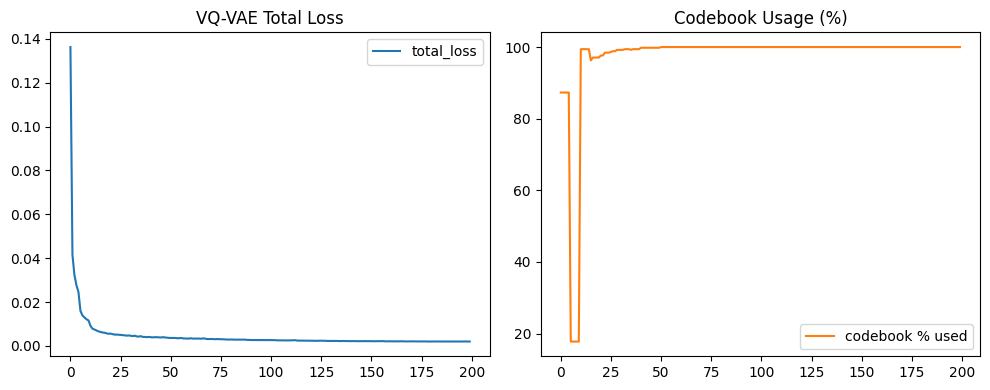

In [18]:
plot_vq_history(history)

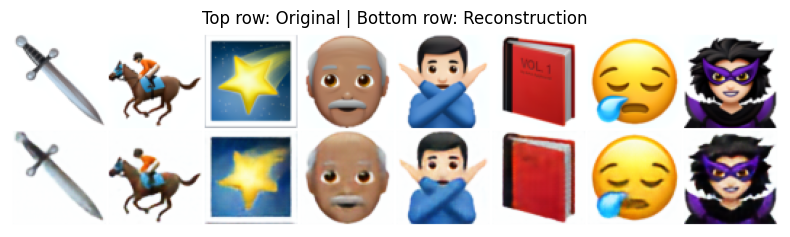

In [19]:
visualize_reconstructions(vq_vae_model, train_loader, n=8)

In [20]:
def extract_latent_codes(model, dataloader, device="cuda"):
    model.eval()
    model.to(device)
    all_indices = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting latent codes"):
            if isinstance(batch, dict):
                for k in ("image", "images", "pixel_values", "img", "input"):
                    if k in batch:
                        imgs = batch[k]
                        break
                else:
                    imgs = None
                    for v in batch.values():
                        if torch.is_tensor(v):
                            imgs = v
                            break
                    if imgs is None:
                        raise RuntimeError("Couldn't find image tensor in dict batch.")
            elif isinstance(batch, (list, tuple)):
                imgs = batch[0]
            elif torch.is_tensor(batch):
                imgs = batch
            else:
                raise TypeError(f"Unsupported batch type: {type(batch)}")

            imgs = imgs.to(device)

            z_e = model.encoder(imgs)
            _, _, encoding_indices = model.vq(z_e)
            
            B = encoding_indices.size(0)
            indices_flat_per_image = encoding_indices.view(B, -1).cpu().numpy()
            all_indices.append(indices_flat_per_image)

    if len(all_indices) == 0:
        return np.zeros((0, 0), dtype=np.int64)

    all_indices = np.concatenate(all_indices, axis=0)
    return all_indices

In [21]:
def analyze_codebook_usage(all_indices, num_embeddings, save_dir="./vqvae_analysis"):
    os.makedirs(save_dir, exist_ok=True)

    flat_indices = all_indices.flatten()
    unique, counts = np.unique(flat_indices, return_counts=True)

    usage_ratio = len(unique) / num_embeddings * 100
    print(f"Codebook utilization: {len(unique)} / {num_embeddings} ({usage_ratio:.2f}%)")

    plt.figure(figsize=(8,4))
    plt.bar(unique, counts, width=0.8)
    plt.title("Codebook Usage Frequency")
    plt.xlabel("Codebook Index")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "code_usage_histogram.png"))
    plt.show()

    probs = counts / np.sum(counts)
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    max_entropy = np.log(len(probs))
    entropy_ratio = entropy / max_entropy if max_entropy > 0 else 0.0
    print(f"Entropy: {entropy:.4f} ({entropy_ratio*100:.2f}% of max)")

Extracting latent codes:   0%|          | 0/22 [00:00<?, ?it/s]

Codebook utilization: 510 / 512 (99.61%)


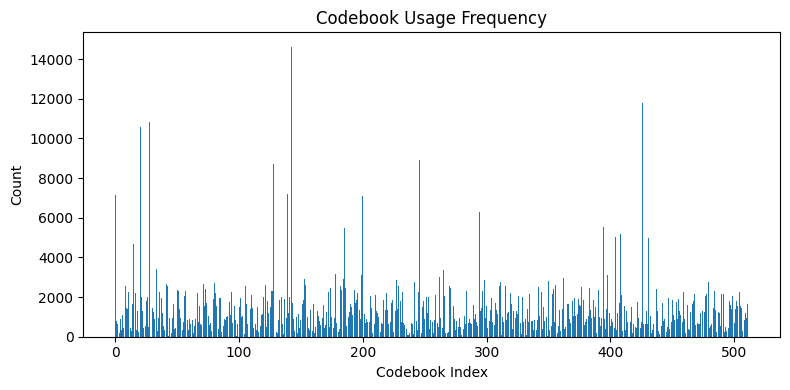

Entropy: 5.8828 (94.36% of max)


In [22]:
all_indices = extract_latent_codes(vq_vae_model, train_loader, device=DEVICE)

analyze_codebook_usage(all_indices, num_embeddings=vq_vae_model.vq.num_embeddings, save_dir="/kaggle/working/vqvae_analysis")

In [23]:
def _extract_images_from_batch(batch):
    if isinstance(batch, dict):
        for k in ("image", "images", "pixel_values", "img", "input"):
            if k in batch:
                return batch[k]
        # fallback: first tensor-like value
        for v in batch.values():
            if torch.is_tensor(v):
                return v
    elif isinstance(batch, (list, tuple)):
        return batch[0]
    elif torch.is_tensor(batch):
        return batch
    raise TypeError(f"Unsupported batch type: {type(batch)}")

def evaluate_vqvae_reconstruction_metrics(
    model,
    dataloader,
    device=DEVICE,
    max_batches: int = 50,
    verbose: bool = True
):
    model.eval()
    model.to(device)

    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    total_mse = 0.0
    total_psnr = 0.0
    n_batches = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Eval MSE/PSNR/SSIM")):
            if i >= max_batches:
                break

            imgs = _extract_images_from_batch(batch).to(device)

            out = model(imgs)
            # support different forward signatures
            if isinstance(out, (list, tuple)):
                recon = out[0]
            else:
                recon = out

            # clamp to [0,1]
            imgs_clamped = torch.clamp(imgs, 0.0, 1.0)
            recon_clamped = torch.clamp(recon, 0.0, 1.0)

            # MSE (batch mean)
            batch_mse = F.mse_loss(recon_clamped, imgs_clamped, reduction="mean").item()
            total_mse += batch_mse

            # PSNR per-batch (assume max pixel value = 1.0)
            eps = 1e-12
            batch_psnr = 20.0 * math.log10(1.0) - 10.0 * math.log10(batch_mse + eps)
            total_psnr += batch_psnr

            # SSIM (update metric)
            ssim_metric.update(recon_clamped, imgs_clamped)

            n_batches += 1

    if n_batches == 0:
        raise RuntimeError("No batches processed. Check dataloader or set max_batches>0.")

    avg_mse = total_mse / n_batches
    avg_psnr = total_psnr / n_batches
    final_ssim = ssim_metric.compute().item()

    results = {
        "MSE": float(avg_mse),
        "PSNR": float(avg_psnr),
        "SSIM": float(final_ssim),
        "processed_batches": n_batches
    }

    if verbose:
        print("=== VQ-VAE Simple Reconstruction Metrics ===")
        print(f"Processed batches (limit={max_batches}): {n_batches}")
        print(f"MSE : {results['MSE']:.6f}")
        print(f"PSNR: {results['PSNR']:.3f} dB")
        print(f"SSIM: {results['SSIM']:.6f}")

    return results

In [24]:
metrics = evaluate_vqvae_reconstruction_metrics(vq_vae_model, train_loader, device=DEVICE)

Eval MSE/PSNR/SSIM:   0%|          | 0/22 [00:00<?, ?it/s]

=== VQ-VAE Simple Reconstruction Metrics ===
Processed batches (limit=50): 22
MSE : 0.001424
PSNR: 28.472 dB
SSIM: 0.938347
